In [1]:
import numpy as np
from numpy import random
import scipy as sp
import pandas as pd

# import scanpy for dimensionality reduction and plotting
import anndata as ad
from scanpy.api.tl import tsne
from scanpy.api.tl import umap
from scanpy.api.tl import diffmap
from scanpy.api import pp

# set viridis as the default color map
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
mpl.rcParams['image.cmap'] = 'viridis'

In [2]:
# simulation
import tree
import simulation as sim
import sim_utils as sut
import count_model as cmod

In [3]:
rseed = 42
np.random.seed(rseed)

In [4]:
X = np.array(pd.read_csv("/home/npapado/Documents/data/axolotl/blastema_raw.txt", index_col=0))
N, G = X.shape

In [5]:
scalings = np.sum(X, axis=1)
scalings = scalings / np.mean(scalings)

In [6]:
branches = ["progenitor", "nonskeletal", "cartilage", "bone", "intermediate"]
topology = [["progenitor", "nonskeletal"],
            ["progenitor", "intermediate"],
            ["intermediate", "bone"],
            ["intermediate", "cartilage"]]
time = {"progenitor": 12, "nonskeletal": 40, "intermediate": 2, "bone": 27, "cartilage": 23}
t = tree.Tree(topology=topology, G=G, time=time, num_branches=len(branches), branch_points=2, modules=0)

In [7]:
progenitor = pd.read_csv("./learn_dataset/progenitor.csv", index_col=0)
nonskeletal = pd.read_csv("./learn_dataset/nonskeletal.csv", index_col=0)
intermediate = pd.read_csv("./learn_dataset/intermediate.csv", index_col=0)
bone = pd.read_csv("./learn_dataset/bone.csv", index_col=0)
cartilage = pd.read_csv("./learn_dataset/cartilage.csv", index_col=0)

In [8]:
t.add_genes({"progenitor": np.array(progenitor),
            "nonskeletal": np.array(nonskeletal),
            "intermediate": np.array(intermediate),
            "bone": np.array(bone),
            "cartilage": np.array(cartilage)})

In [9]:
progenitor_density = np.array(pd.read_csv("./learn_dataset/progenitor_density.csv", index_col=0)).flatten()
nonskeletal_density = np.array(pd.read_csv("./learn_dataset/nonskeletal_density.csv", index_col=0)).flatten()
intermediate_density = np.array(pd.read_csv("./learn_dataset/intermediate_density.csv", index_col=0)).flatten()
bone_density = np.array(pd.read_csv("./learn_dataset/bone_density.csv", index_col=0)).flatten()
cartilage_density = np.array(pd.read_csv("./learn_dataset/cartilage_density.csv", index_col=0)).flatten()

total_density = np.sum(bone_density) +     \
                np.sum(cartilage_density) + \
                np.sum(progenitor_density) + \
                np.sum(nonskeletal_density) + \
                np.sum(intermediate_density)

In [10]:
tree_density = {"progenitor": progenitor_density / total_density,
                "nonskeletal": nonskeletal_density / total_density,
                "intermediate": intermediate_density / total_density,
                "bone": bone_density / total_density,
                "cartilage": cartilage_density / total_density}

In [11]:
t.set_density(tree_density)

In [12]:
alphas = np.array(pd.read_csv("./learn_dataset/axolotl_alphas.txt", index_col=0)).flatten()
betas = np.array(pd.read_csv("./learn_dataset/axolotl_betas.txt", index_col=0)).flatten()

In [13]:
X1, labs1, brns1, scalings1 = sim.sample_density(t, N,
                                                 alpha=alphas, beta=betas,
                                                 scale_mean=0, scale_v=np.var(scalings))

/home/npapado/Documents/repos/prosstt/dev/count_model.py:158: RuntimeWarning: divide by zero encountered in true_divide
  r = (m**2) / (s2 - m)# if s2 > 0 else 0


In [14]:
scalings1 = np.sum(X1, axis=1)
scalings1 = scalings1 / np.mean(scalings1)

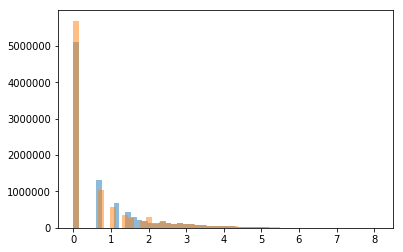

In [15]:
fig, ax = plt.subplots()
h = ax.hist(np.log(X.flatten()+1), bins=50, label="axo", alpha=0.5)
h = ax.hist(np.log(X1.flatten()+1), bins=50, label="sim", alpha=0.5)

In [16]:
X1 = (X1.transpose() / scalings1).transpose()
X = (X.transpose() / scalings).transpose()

In [42]:
br_names1, indices1 = np.unique(brns1, return_inverse=True)

In [17]:
# data1 = ad.AnnData(np.log(X1+1))
# pp.neighbors(data1, n_neighbors=50)
# umap(data1)
# dm1 = data1.obsm["X_umap"]
# br_names1, indices1 = np.unique(brns1, return_inverse=True)

# data2 = ad.AnnData(np.log(X+1))
# pp.neighbors(data2, n_neighbors=50)
# umap(data2)
# dm2 = data2.obsm["X_umap"]

# fig, ax = plt.subplots(ncols=2)
# # fig.set_size_inches(w=12, h=12)
# ax[0].scatter(dm1[:, 0], dm1[:, 1])
# ax[1].scatter(dm2[:, 0], dm2[:, 1])

In [18]:
# data3 = ad.AnnData(np.log(X+1))
# pp.neighbors(data3, n_neighbors=2000)
# umap(data3)
# dm3 = data3.obsm["X_umap"]
# fig, ax = plt.subplots(ncols=2)
# # fig.set_size_inches(w=12, h=12)
# ax[0].scatter(dm1[:, 0], dm1[:, 1])
# ax[1].scatter(dm3[:, 0], dm3[:, 1])

In [19]:
together = np.concatenate((X, X1))
original = ["original"] * N
simulated = ["simulated"] * N
origin = np.concatenate((original, simulated))

         Falling back to preprocessing with `sc.pp.pca` and default params.


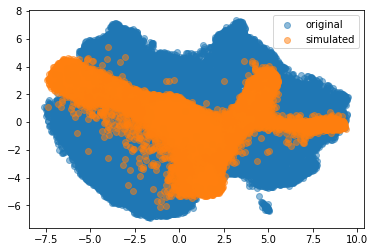

In [22]:
data = ad.AnnData(np.log(together+1))
pp.neighbors(data)
umap(data)
dm = data.obsm["X_umap"]

In [26]:
merlot_branches = np.array(pd.read_csv("./learn_dataset/axolotl_merlot.txt", index_col=0)).flatten()

In [36]:
merlot_names = ["progenitor", "nonskeletal", "intermediate", "bone", "cartilage"]

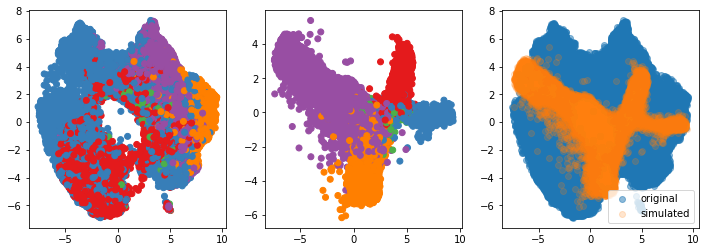

In [44]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(w=12, h=4)

# for i, b in enumerate(np.unique(merlot_branches)):
#     axolotl = (origin=="original")
#     onbranch = (merlot_branches == b)
#     toplot = axolotl[onbranch]
#     ax[0].scatter(dm[toplot, 0], dm[toplot, 1], label=merlot_names[i])
    
ax[0].scatter(dm[origin=="original", 0], dm[origin=="original", 1], c=cm.Set1(merlot_branches-1))
ax[1].scatter(dm[origin=="simulated", 0], dm[origin=="simulated", 1], c=cm.Set1(indices1))
ax[2].scatter(dm[origin=="original", 0], dm[origin=="original", 1], label="original", alpha=0.5)
ax[2].scatter(dm[origin=="simulated", 0], dm[origin=="simulated", 1], label="simulated", alpha=0.2)
ax[2].legend()